In [1]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

# Viz libraries
import altair as alt
import hela.visualization.hmm as hmmplot 
import matplotlib.pyplot as plt
from hela.visualization.hmm import TU_COLORS
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools
from IPython.display import Image

# PGMPy
from hela.graphical_hmm import DynamicBayesianNetwork as dbn
# from hela.graphical_hmm.ContinuousFactor import ContinuousFactor
# from pgmpy.factors.discrete import TabularCPD


/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### HMM Generative Model

In [2]:
generative_model = hmm_gen.DiscreteHMMGenerativeModel(
                                     n_hidden_states =3,
                                     n_gaussian_features=1,
                                    n_categorical_features = 2,
                                     n_gmm_components = None)

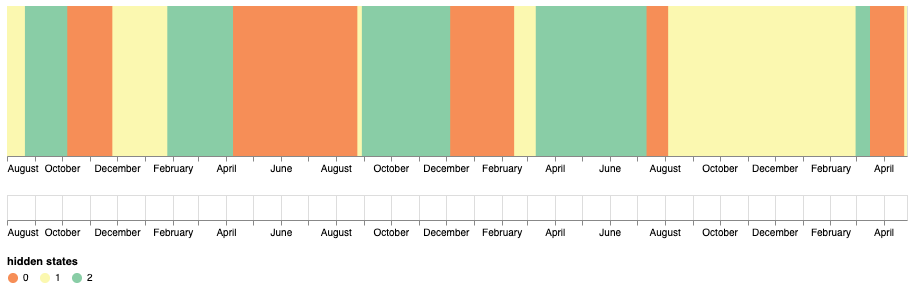

In [3]:
hidden_states = generative_model.generate_hidden_state_sequence(n_observations = 1000)
hmmplot.draw_states(hidden_states, hide_brush=False)

In [4]:
hmm_data = generative_model.generate_observations(hidden_states)
hmm_training_spec = generative_model.generative_model_to_discrete_hmm_training_spec()
model_config = hmm.DiscreteHMMConfiguration.from_spec(hmm_training_spec)
hmm_model = model_config.to_model()

### PGMpy Structure of HMM

![HMM_graph](hmm_graph.png)

In [5]:
hmm_graph = dbn.hmm_model_to_graph(hmm_model)

In [6]:
for node in hmm_graph.nodes:
    print("latent status for node {} at t = {}: ".format(node[0], node[1]), 
          hmm_graph.nodes[node])

latent status for node hs at t = 0:  {'latent': True}
latent status for node hs at t = 1:  {'latent': True}
latent status for node cont_obs at t = 0:  {'latent': False}
latent status for node cont_obs at t = 1:  {'latent': False}
latent status for node cat_obs at t = 0:  {'latent': False}
latent status for node cat_obs at t = 1:  {'latent': False}


In [7]:
hmm_graph.get_factors(time_slice=0)

[[<TabularCPD representing P(('cat_obs', 0):6 | ('hs', 0):3) at 0x7f73db374f98>],
 [<TabularCPD representing P(('hs', 0):3) at 0x7f73db374fd0>]]

In [8]:
hmm_graph.get_factors(time_slice=1)

[[<TabularCPD representing P(('cat_obs', 1):6 | ('hs', 1):3) at 0x7f73db374518>],
 [<TabularCPD representing P(('hs', 1):3 | ('hs', 0):3) at 0x7f73db374e10>]]

In [9]:
# This checks that the CPD tables between edges are valid

hmm_graph.check_model()

True

In [10]:
hmm_graph.edges()

OutEdgeView([(('hs', 0), ('hs', 1)), (('hs', 0), ('cont_obs', 0)), (('hs', 0), ('cat_obs', 0)), (('hs', 1), ('cont_obs', 1)), (('hs', 1), ('cat_obs', 1))])

### FHMM Generative Model

In [11]:
gen = hmm_gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[3, 2],
                                     n_gaussian_features = 1,
                                     n_categorical_features = 2)

factored_hidden_states = gen.generate_hidden_state_sequence(n_observations = 500)

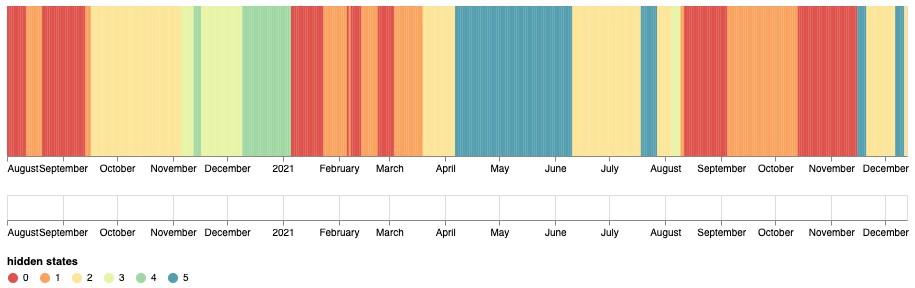

In [12]:
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

In [13]:
data = gen.generate_observations(factored_hidden_states)
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(factored_hidden_states, 
                                   gen.ns_hidden_states, 
                                   data,
                                   categorical_features = list(gen.categorical_values.columns), 
                                   gaussian_features = list(gen.gaussian_values.columns))

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)
fhmm_model = fhmm_config.to_model()

### PGMpy Structure of FHMM

For the edge factors in an FHMM graph, each transition arrow is defined by the corresponding transition matrix for that system.  For categorical data, we define the marginalized emission probability for each emission edge.  For continous data, the edge is defined by the W matrix and covariance matrix.  In the learning/inference process these will be used to generate the pdf for a given hs vector.

In [14]:
fhmm_graph = dbn.fhmm_model_to_graph(fhmm_model)

In [15]:
for node in fhmm_graph.nodes:
    print("latent status for node {} at time step {}: ".format(node[0], node[1]), 
          fhmm_graph.nodes[node])

latent status for node system_0 at time step 0:  {'latent': True}
latent status for node system_0 at time step 1:  {'latent': True}
latent status for node system_1 at time step 0:  {'latent': True}
latent status for node system_1 at time step 1:  {'latent': True}
latent status for node cont_obs at time step 0:  {'latent': False}
latent status for node cont_obs at time step 1:  {'latent': False}
latent status for node cat_obs at time step 0:  {'latent': False}
latent status for node cat_obs at time step 1:  {'latent': False}


In [16]:
fhmm_graph.edges()

OutEdgeView([(('system_0', 0), ('system_0', 1)), (('system_0', 0), ('cont_obs', 0)), (('system_0', 0), ('cat_obs', 0)), (('system_0', 1), ('cont_obs', 1)), (('system_0', 1), ('cat_obs', 1)), (('system_1', 0), ('system_1', 1)), (('system_1', 0), ('cont_obs', 0)), (('system_1', 0), ('cat_obs', 0)), (('system_1', 1), ('cont_obs', 1)), (('system_1', 1), ('cat_obs', 1))])

In [17]:
fhmm_graph.check_model()

True

In [18]:
fhmm_graph.get_factors(time_slice=0)


[[<TabularCPD representing P(('cat_obs', 0):6 | ('system_0', 0):3) at 0x7f73db377160>,
  <TabularCPD representing P(('cat_obs', 0):6 | ('system_1', 0):2) at 0x7f73db350a58>],
 [<TabularCPD representing P(('system_0', 0):3) at 0x7f73db377748>],
 [<TabularCPD representing P(('system_1', 0):2) at 0x7f73db350710>]]

In [19]:
fhmm_graph.get_factors(time_slice=1)

[[<TabularCPD representing P(('cat_obs', 1):6 | ('system_0', 1):3) at 0x7f73db377198>,
  <TabularCPD representing P(('cat_obs', 1):6 | ('system_1', 1):2) at 0x7f73db350470>],
 [<TabularCPD representing P(('system_0', 1):3 | ('system_0', 0):3) at 0x7f73db3772e8>],
 [<TabularCPD representing P(('system_1', 1):2 | ('system_1', 0):2) at 0x7f73db350fd0>]]